In [182]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nibabel as nib
from dipy.segment.mask import median_otsu

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [163]:
img  = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/REDIM_diravg.nii.gz")
seg = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/B0_WMPARC.nii.gz")

signal = np.flip(img.get_fdata(), axis = 0) # always flip it along axis 0 such that the plots match the views in MRView
seg = np.flip(seg.get_fdata(), axis = 0)    # so does the provided seg data

# **********************************
signal = signal[0:30, 0:30, 0:30, :]
# **********************************

mask, lin2idx = bf.mask_brain(signal, median_radius = 1, numpass = 4, least_size = 300, keep_top = 3)

+-----------------------------------------------------------------------------+
Number of initial valid regions: 1
Sizes of each regions (1st is background): [26337   663]
+-----------------------------------------------------------------------------+
Number of kept regions: 1
Sizes of kept regions: [663]
+-----------------------------------------------------------------------------+


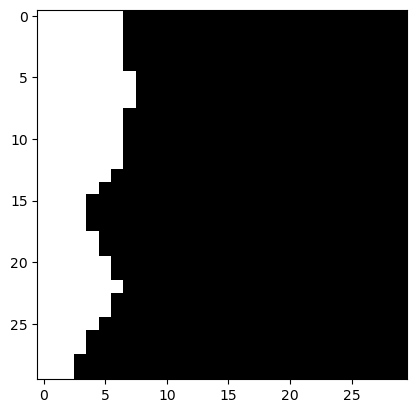

In [164]:
plt.imshow(np.fliplr(np.flipud(mask[29, :, :].T)), cmap='gray')
plt.show()

In [165]:
bvals = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/bvals.txt") / 1000 # in unit ms/{\mu m} ^2
TEs = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/TEs.txt")/1000  # in unit s
qs = np.column_stack((bvals, TEs))

In [166]:
signal_norm = signal[:,:,:,qs[:,0]!=0] / np.repeat(signal[:,:,:,qs[:,0]==0], 5, axis = -1)
qs_norm = np.delete(qs, qs[:, 0] == 0, axis = 0)
Sqs = signal_norm[mask, :].reshape((-1, qs_norm.shape[0]), order = 'C')

In [167]:
signal_norm.shape

(30, 30, 30, 25)

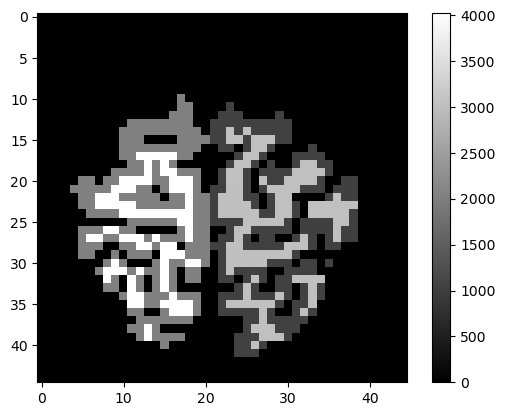

In [168]:
plt.imshow(np.fliplr(np.rot90(seg[25:70:, 25:70, 43])), cmap = 'gray') 
plt.colorbar()
plt.show()

In [23]:
theta1 = np.linspace(0, 3, 50)
theta2 = np.linspace(0, 40, 50)
thetas, weights = bf.Cartesian(theta1, theta2)
R = rr.R_mask(mask, 25, order = 2)

In [ ]:
std_vector = 0.01*np.ones(len(Sqs))
sigma = np.repeat(std_vector, 25)

for i in range(1):
    _, f_est, hisotry = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                            R_csr = sp.csr_matrix(R.shape), f0 = None, normalize = True,
                            Lambdas = None, rho = 1e-2, rho_ratio = 3, dynamic_rho = False, 
                            beta = 0.1, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 2,
                            cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                            admm_tol = 1e-10, admm_maxiter = 200)

    Sqs_est = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_est)

    diff = Sqs - Sqs_est
    std_vector = np.std(diff, axis = 1)
    sigma = np.repeat(std_vector, 25)


ADMM maximum iterations reached.


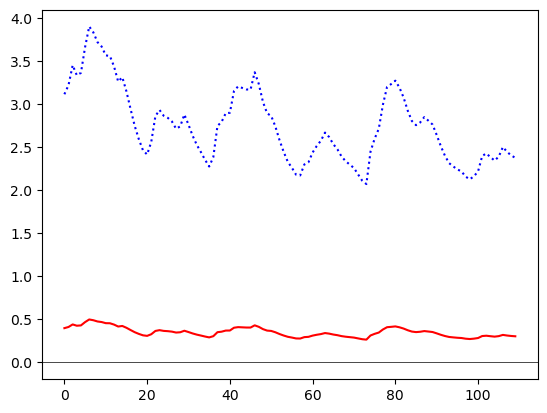

In [181]:
plt.plot(hisotry[1][90:], '-', color = 'red', label = 'primal')
plt.plot(hisotry[2][90:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()

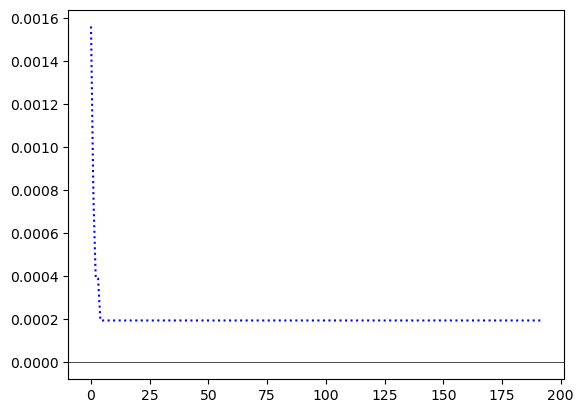

In [174]:
plt.plot(hisotry[3][6:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()

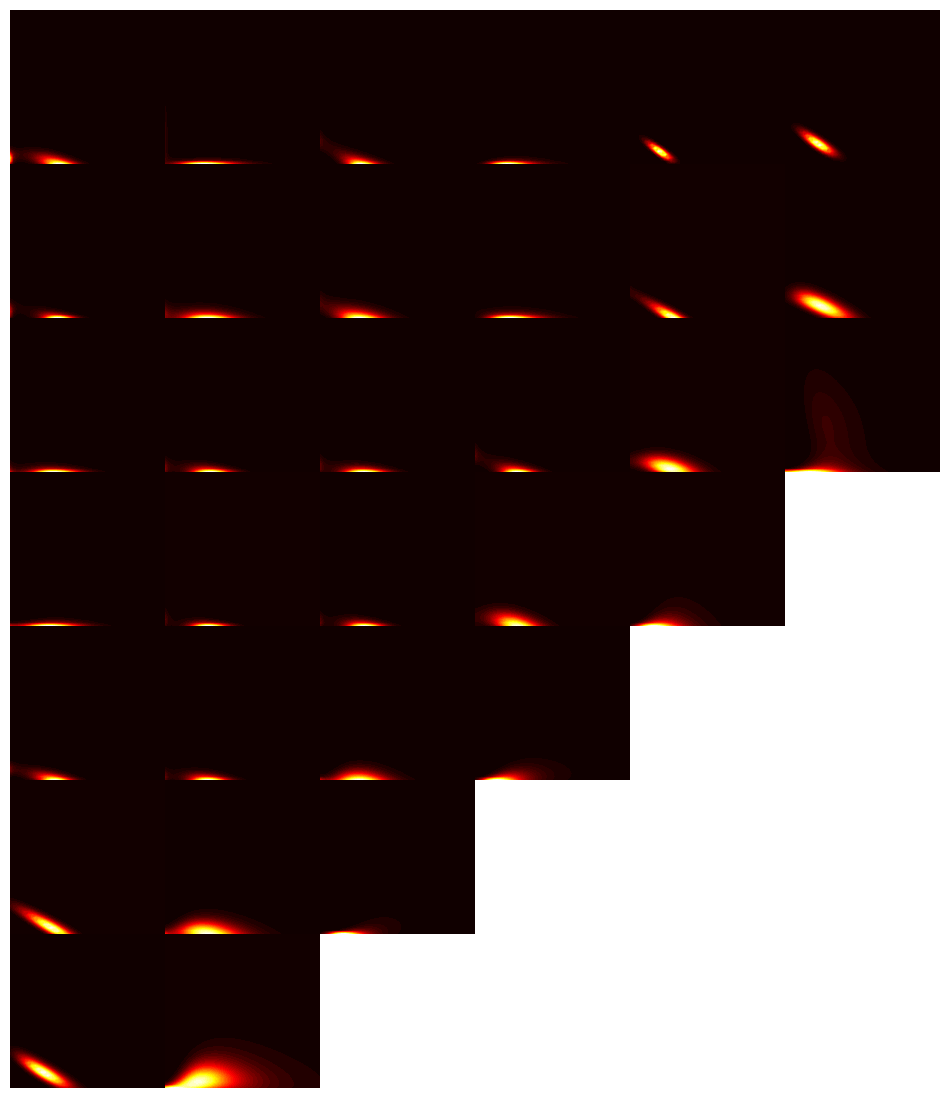

In [161]:
bf.contourf_mask(theta1, theta2, f_est, lin2idx, axis = 2, slice = 19)

In [141]:
theta2.max() - theta2.min()

np.float64(40.0)

Mean of sigma is: 0.11021771554985381


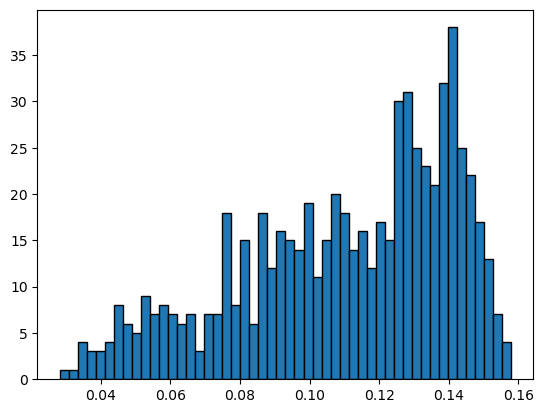

In [36]:
# sigma[sigma <= 0.01] = 0.01
print("Mean of sigma is:", np.mean(sigma))
plt.hist(std_vector, bins = 50, edgecolor = 'black')
plt.show()

In [43]:
lambdas, f_hat, obj_history = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                                        R_csr = R, f0 = None, normalize = True,
                                        Lambdas = None, rho = 5e-1, rho_ratio = 3,dynamic_rho = True,
                                        beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                                        cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                                        admm_tol = 1e-10, admm_maxiter = 200)


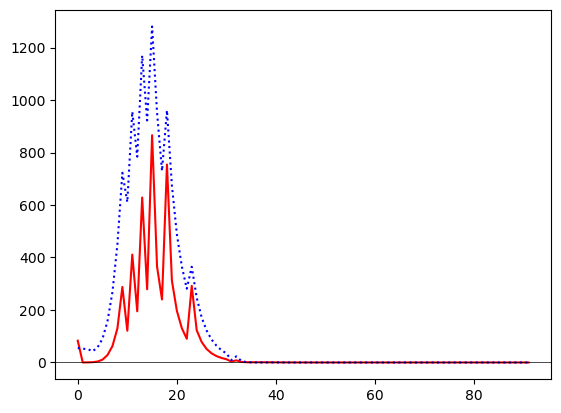

In [44]:
plt.plot(obj_history[1][:], '-', color = 'red', label = 'primal')
plt.plot(obj_history[2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()


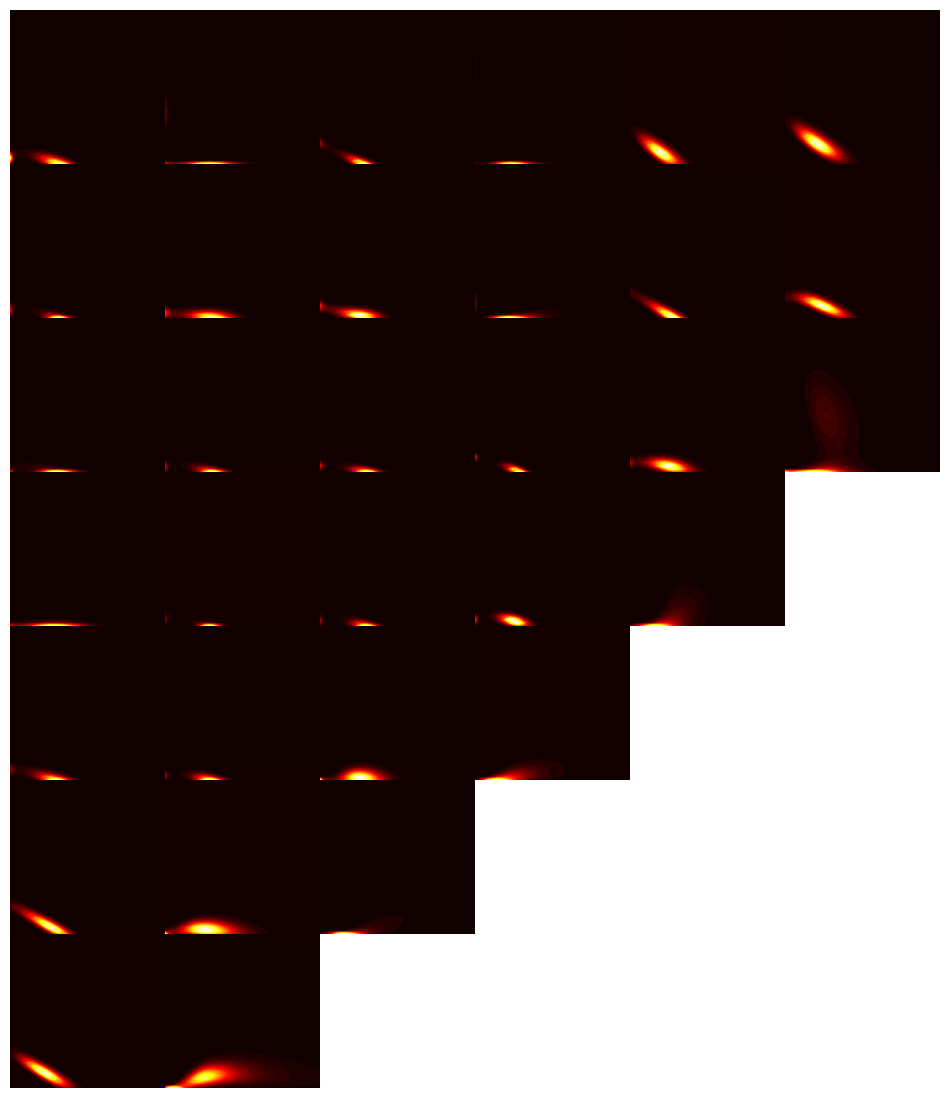

In [45]:
bf.contourf_mask(theta1, theta2, f_hat, lin2idx, axis = 2, slice = 19)

# Compare

In [145]:
import torch
hpc = torch.load("/Users/xunan/Downloads/R_0_solution.pt", map_location="cpu")
print(type(hpc))
print(hpc.keys() if isinstance(hpc, dict) else hpc.shape)

<class 'dict'>
dict_keys(['std_vector', 'R', 'theta1', 'theta2', 'lin2idx', 'lambdas', 'f_hat', 'history'])


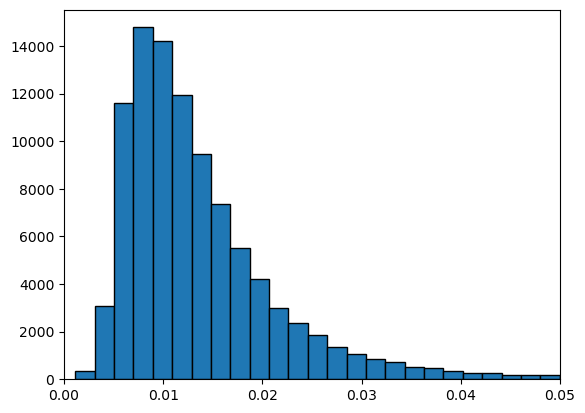

In [146]:
plt.hist(hpc['std_vector'], bins = 300, edgecolor = 'black')
plt.xlim(0, 0.05)
plt.show()

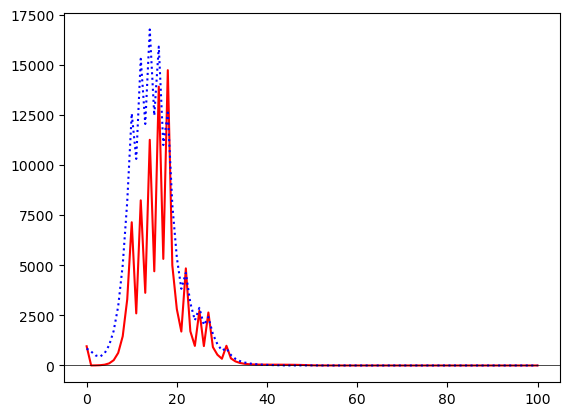

In [148]:
plt.plot(hpc['history'][1][:], '-', color = 'red', label = 'primal')
plt.plot(hpc['history'][2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()

In [153]:
bf.contourf_mask(   hpc['theta1'], 
                    hpc['theta2'], 
                    hpc['f_hat'].numpy(), 
                    hpc['lin2idx'].numpy(), 
                    axis = 1, slice = 31)

In [19]:
Sqs[:, torch.arange(Sqs.shape[1]) != i].shape

(663, 24)

In [18]:
idx = hpc['lin2idx'].numpy().astype(np.intp)            # ensure integer index type
out = np.zeros(hpc['lin2idx'].numpy().shape, dtype=hpc['std_vector'].numpy().dtype)
mask = idx >= 0
out[mask] = hpc['std_vector'][idx[mask]]

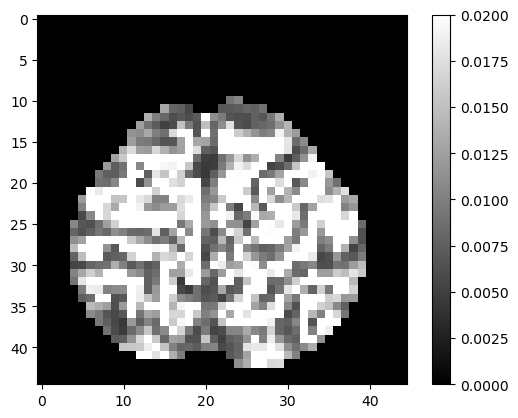

In [21]:
plt.imshow(np.fliplr(np.rot90(out[25:70:, 25:70, 43])), vmin=0.0, vmax=0.02, cmap = 'gray')# , vmin = 0, vmax = 4029)
plt.colorbar()
plt.show()